In [26]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
import sys
import copy 
import warnings
import cProfile

import _pickle as pickle

from time import time

from astropy.stats import sigma_clip
from astropy.table import Table, Column, vstack
from scipy.ndimage.filters import gaussian_filter

import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from astroML.stats import binned_statistic_2d

from asap import io
from asap import smf 
from asap import config
from asap import fitting
from asap import ensemble
from asap import plotting
from asap import predictions
from asap.parameters import AsapParams
from asap.likelihood import ln_likelihood, ln_probability
from asap.predictions import (predict_mstar_basic, predict_smf, predict_mhalo,
                              predict_dsigma_profiles, make_model_predictions)

plt.rc('text', usetex=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Assign halo mass to HSC galaxies using results of the A.S.A.P model

In [2]:
test_dir = 'test/final'

# The configuration file
config_file = os.path.join(test_dir, 'asap_test_1.yaml')

# Initialize the model, load the data
cfg, params, obs_data, um_data = fitting.initial_model(config_file, verbose=True)


# The results of the final sampling process
result_file = os.path.join(test_dir, 'asap_test_1_sample.npz')

# Load in the final sampling results
(mod_result_samples, 
 mod_result_chains, 
 mod_result_lnprob, 
 mod_result_best, _, _) = io.load_npz_results(result_file)

# Predict the stellar mass in inner and outer apertures
logms_inn, logms_tot, sig_logms, mask_use = predict_mstar_basic(
    um_data['um_mock'], mod_result_best, min_logms=10.5,
    logmh_col=cfg['um']['logmh_col'], min_scatter=cfg['um']['min_scatter'],
    pivot=cfg['um']['pivot_logmh'])

# Predict the SMFs and DeltaSigma profiles
um_smf_tot, um_smf_inn, um_dsigma = make_model_predictions(
    mod_result_best, cfg, obs_data, um_data)

# Check the likelihood for SMF and DeltaSigma profiles
lnlike_smf, lnlike_dsigma = ln_likelihood(
    mod_result_best, cfg, obs_data, um_data, sep_return=True)

# The useful part of the mock catalog
um_mock_use = um_data['um_mock'][mask_use]

print("\n# Best parameters: ", mod_result_best)
print("# ln(Likelihood) for SMFs   : %8.4f" % lnlike_smf)
print("# ln(Likelihood) for DSigma : %8.4f" % lnlike_dsigma)

# Running model: asap_test_1
#    Will use emcee as sampler ...
#    Use   256 walkers with    snooker moves for   180 x  3 steps of burn-in
#    Use   256 walkers with        kde moves for   400 steps of sampling

# Observations:
# Galaxy catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# DSigma results: s16a_wide2_dsigma_logm11.6_12_bins.npy
# SMF of inner Mstar: s16a_wide2_massive_smf_m10_11.6.npy
# SMF of total Mstar: s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: s16a_wide2_massive_smf_mmax_m10_cov.npy
# Reference SMF: primus_smf_z0.3_0.4.fits
# Column of inner Mstar: logm_10
# Column of total Mstar: logm_max

# UniverseMachine:
# Galaxy catalog : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_short.npy
# DSigma results : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_50m_r_0.08_50_22bins.npy
# Volumn of the simulation:    205348196.23 Mpc^3
# Halo mass : logmh_host
# Stellar mass : logms_tot
# There are 12 DSigma profiles in this sample
# SMF for total stella

In [3]:
# Get the predicted aperture stellar mass and halo mass for central galaxies

um_mock_use = um_data['um_mock'][mask_use]

mask_cen = um_mock_use['upid'] == -1
um_mock_cen = um_mock_use[mask_cen]

logms_tot_cen = logms_tot[mask_cen]
logms_inn_cen = logms_inn[mask_cen]
logmh_vir_cen = um_mock_cen['logmh_vir']
logmh_peak_cen = um_mock_cen['logmh_peak']

# Aperture mass array for UM mock galaxies
um_mass = np.stack((logms_inn_cen, logms_tot_cen), axis=-1)

### Read in the HSC galaxy catalog

In [4]:
hsc_mass = Table.read(
    os.path.join(cfg['obs']['dir'], 's16a_wide2_massive_fsps1_imgsub_use_short.fits'))

print("# There are %d HSC galaxies" % len(hsc_mass))

# There are 38653 HSC galaxies


In [5]:
# Select relevant galaxies, exclude the ones with unreasonable mass and size
hsc_good = hsc_mass[(hsc_mass['r50_max'] >= 1.0) & (hsc_mass['r50_max'] <= 50.0) &
                    (hsc_mass['logm_max'] >= 11.2) & (hsc_mass['logm_max'] <= 12.5) &
                    (hsc_mass['logm_10'] >= 10.75) & (hsc_mass['logm_10'] <= 11.75)]

print("# There are %d good HSC massive galaxies" % len(hsc_good))

hsc_mhalo = copy.deepcopy(hsc_mass)

# Aperture mass array for HSC massive galaxies
hsc_aper_mass = np.stack((np.array(hsc_mass['logm_10']), np.array(hsc_mass['logm_max'])), axis=-1)

# There are 28860 good HSC massive galaxies


### Assign halo mass using random forest regressor

In [8]:
from sklearn.ensemble import RandomForestRegressor

# Build the random forest regressor
mstar_forest = RandomForestRegressor(
    n_estimators=20, criterion='mse', max_depth=None, random_state=None, n_jobs=-1)

# Fit the data
mstar_forest.fit(um_mass, logmh_vir_cen)

# Predict halo mass
mvir_forest = mstar_forest.predict(hsc_aper_mass)

# Save the model
from sklearn.externals import joblib

joblib.dump(mstar_forest, 'data/um_asap_default_mvir_random_forest.pkl') 

['data/um_asap_default_mvir_random_forest.pkl']

In [10]:
# Add a column
hsc_mhalo.add_column(Column(data=mvir_forest, name='logmh_vir_forest'))

[0.26274780586873775, 0.10643317112210633, 0.11901739376868478, 0.13008428514565595, 0.13337355543117815, 0.13483770206035522, 0.13479856392536937, 0.13127744707956757, 0.11327202751899104, 0.10160770700326281, 0.11124666413434964, 0.0]


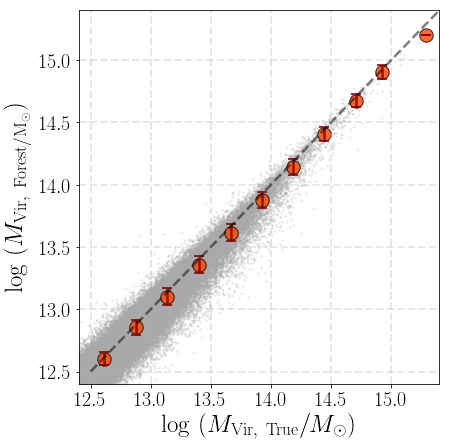

In [9]:
fig_1 = plt.figure(figsize=(6, 6))
fig_1.subplots_adjust(left=0.16, right=0.995, bottom=0.13, top=0.995, wspace=0.00, hspace=0.00)

ax1 = fig_1.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.3, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

# Scatter
um_mvir_forest = mstar_forest.predict(um_mass)

ax1.scatter(um_mock_cen['logmh_vir'], um_mvir_forest, s=2, alpha=0.2, c='darkgray')

# Mean and std
logmh_bin = np.linspace(12.5, 15.4, 12)

idx_logmh = np.digitize(um_mock_cen['logmh_vir'], logmh_bin)

logmh_mean_um = [np.nanmedian(um_mock_cen['logmh_vir'][idx_logmh == k]) 
                 for k in range(len(logmh_bin))]

logmh_mean_forest = [np.nanmedian(um_mvir_forest[idx_logmh == k]) 
                     for k in range(len(logmh_bin))]

sigmh_forest = [np.nanstd(um_mvir_forest[idx_logmh == k]) 
                for k in range(len(logmh_bin))]

print(sigmh_forest)

ax1.scatter(logmh_mean_um, logmh_mean_forest, s=180, alpha=0.8, edgecolor='k',
            facecolor='orangered')

ax1.errorbar(logmh_mean_um, logmh_mean_forest, yerr=np.asarray(sigmh_forest)/2.0, 
             fmt='o', ecolor='maroon', elinewidth=2.5, capsize=5, capthick=2.0,
             color='orangered', markersize=0, alpha=0.8,
             markeredgecolor='none', zorder=1)
    
ax1.plot(np.linspace(12.5, 15.9, 10), np.linspace(12.5, 15.9, 10), 
         linestyle='--', linewidth=2.5, c='k', alpha=0.5)

ax1.set_xlim(12.4, 15.4)
ax1.set_ylim(12.4, 15.4) 

_ = ax1.set_xlabel(r'$\log\ (M_{\rm Vir,\ True}/M_{\odot})$', fontsize=25)
_ = ax1.set_ylabel(r'$\log\ (M_{\rm Vir,\ Forest/M_{\odot}})$', fontsize=25)

### Assign halo mass using best-fit Mhalo-Mmax-M10 relation

/Users/song/Dropbox/work/code/cappellari/lts_fits/lts_planefit.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  abc = np.linalg.lstsq(a*sw[:, None], z*sw)[0]


sig_int:     0.0000     11.5402
Computing sig_int
sig_int:     0.0000     11.5402
sig_int:     0.1927     -0.2873
sig_int:     0.1880     -0.2538
sig_int:     0.1533      0.0954
sig_int:     0.1628     -0.0205
sig_int:     0.1611     -0.0014
sig_int:     0.1610      0.0000
Computing sig_int error
sig_int:     0.1610      0.0179
sig_int:     0.1927     -0.2694
sig_int:     0.1630     -0.0047
sig_int:     0.1626     -0.0001
sig_int:     0.1625      0.0009
Repeat at best fitting solution
sig_int:     0.1610      0.0000
################################# Values and formal errors
 intercept:  13.6901 +/- 0.0021
    slopeX:  3.257 +/- 0.022
    slopeY:  -2.456 +/- 0.025
   scatter:  0.161 +/- 0.0016
Observed rms scatter: 0.166 
a + b*(x-pivotx) + c*(y-pivoty) with pivotx = 11.72 & pivoty = 11.34
##########################################################
seconds 62.20


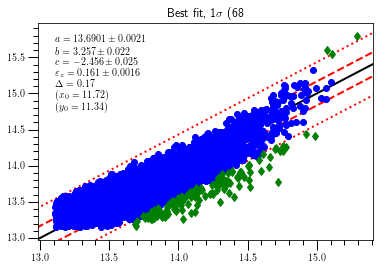

In [11]:
from lts_planefit import lts_planefit

# Only use massive central galaxies
mask_fit = (logms_tot_cen >= 11.6)

x_mmax = logms_tot_cen[mask_fit]
y_minn = logms_inn_cen[mask_fit]
z_mhalo = um_mock_cen[mask_fit]['logmh_vir']

x_sig = sig_logms[mask_cen][mask_fit]
y_sig = sig_logms[mask_cen][mask_fit]
z_sig = sig_logms[mask_cen][mask_fit]

p = lts_planefit(x_mmax, y_minn, z_mhalo, x_sig, y_sig, z_sig, 
                 frac=0.9, pivotx=np.mean(x_mmax), pivoty=np.mean(y_minn))

c_plane, a_plane, b_plane = p.abc
a_pivot, b_pivot = np.mean(x_mmax), np.mean(y_minn)

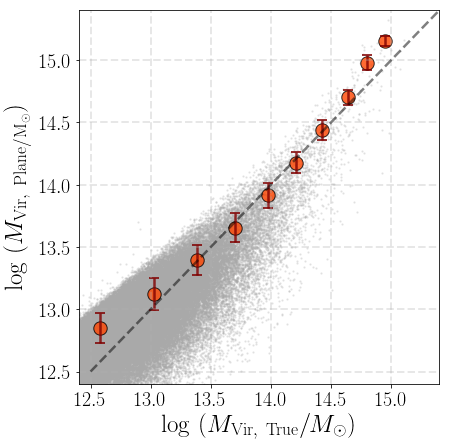

In [12]:
fig_2 = plt.figure(figsize=(6, 6))
fig_2.subplots_adjust(left=0.16, right=0.995, bottom=0.13, top=0.995, wspace=0.00, hspace=0.00)

ax1 = fig_2.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.3, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
# Scatter plot
logmh_plane_mod = (a_plane * (logms_tot_cen - a_pivot) + 
                   b_plane * (logms_inn_cen - b_pivot) + c_plane)

ax1.scatter(um_mock_cen['logmh_vir'], logmh_plane_mod, s=2, alpha=0.2, color='darkgray')

# Mean and std
logmh_bin = np.linspace(12.5, 15.4, 12)

idx_logmh = np.digitize(logmh_plane_mod, logmh_bin)

logmh_mean_um = [np.nanmedian(um_mock_cen['logmh_vir'][idx_logmh == k]) 
                 for k in range(len(logmh_bin))]

logmh_mean_plane = [np.nanmedian(logmh_plane_mod[idx_logmh == k]) 
                    for k in range(len(logmh_bin))]

sigmh_plane = [np.nanstd(um_mock_cen['logmh_vir'][idx_logmh == k]) 
               for k in range(len(logmh_bin))]

ax1.scatter(logmh_mean_um, logmh_mean_plane, s=180, alpha=0.8, edgecolor='k',
            facecolor='orangered')

ax1.errorbar(logmh_mean_um, logmh_mean_plane, yerr=np.asarray(sigmh_plane)/2.0, 
             fmt='o', ecolor='maroon', elinewidth=2.5, capsize=5, capthick=2.0,
             color='orangered', markersize=0, alpha=0.8,
             markeredgecolor='none', zorder=1)

# One-to-one relation
ax1.plot(np.linspace(12.5, 15.9, 10), np.linspace(12.5, 15.9, 10), 
         linestyle='--', linewidth=2.5, c='k', alpha=0.5)

ax1.set_xlim(12.4, 15.4)
ax1.set_ylim(12.4, 15.4) 

_ = ax1.set_ylabel(r'$\log\ (M_{\rm Vir,\ Plane/M_{\odot}})$', fontsize=25)
_ = ax1.set_xlabel(r'$\log\ (M_{\rm Vir,\ True}/M_{\odot})$', fontsize=25)

#### The best-fit aperture mass plane 

* 13.6901 + 3.257 * (logm_max - 11.72) - 2.456 * (logm_10 - 11.34)

In [13]:
# Best-fit plane
mvir_plane = a_plane * (hsc_mhalo['logm_max'] - a_pivot) + b_plane * (hsc_mhalo['logm_10'] - b_pivot) + c_plane

hsc_mhalo.add_column(Column(data=mvir_plane, name='logmh_vir_plane'))

In [14]:
def assign_mvir_plane(logm_max, logm_10, a_plane=3.257, a_pivot=11.72, b_plane=-2.456, b_pivot=11.34,
                      c_plane=13.6901):
    """Assign Mvir to galaxies with observed aperture masses."""
    return a_plane * (logm_max - a_pivot) + b_plane * (logm_10 - b_pivot) + c_plane

### Assign halo mass using more complex relation built by symbolic regression

In [15]:
from gplearn.genetic import SymbolicRegressor

um_mvir = um_mock_cen['logmh_vir']

mask_fit = logms_tot_cen >= 11.5

est_gp = SymbolicRegressor(population_size=5000, 
                           const_range=(-35.0, 35.0),
                           metric='mse',
                           generations=500, stopping_criteria=0.004,
                           p_crossover=0.9, p_subtree_mutation=0.01,
                           p_hoist_mutation=0.01, p_point_mutation=0.01,
                           max_samples=0.95, verbose=0, n_jobs=-1,
                           parsimony_coefficient=0.001, 
                           random_state=0)

est_gp.fit(um_mass[mask_fit], um_mvir[mask_fit])

SymbolicRegressor(const_range=(-35.0, 35.0),
         function_set=('add', 'sub', 'mul', 'div'), generations=500,
         init_depth=(2, 6), init_method='half and half', max_samples=0.95,
         metric='mse', n_jobs=-1, p_crossover=0.9, p_hoist_mutation=0.01,
         p_point_mutation=0.01, p_point_replace=0.05,
         p_subtree_mutation=0.01, parsimony_coefficient=0.001,
         population_size=5000, random_state=0, stopping_criteria=0.004,
         tournament_size=20, verbose=0, warm_start=False)

In [16]:
print(est_gp._program)

sub(add(sub(X1, X0), div(sub(add(sub(X1, X0), div(13.516, X0)), sub(X0, add(X1, X1))), X0)), sub(X0, add(X1, X1)))


In [27]:
with open('data/um_asap_default_mvir_symbolic_regression.pkl', 'wb') as f:
    pickle.dump(est_gp, f)

In [28]:
f.close()

In [20]:
mvir_symbol = est_gp.predict(hsc_aper_mass)

hsc_mhalo.add_column(Column(data=mvir_symbol, name='logmh_vir_symbol'))

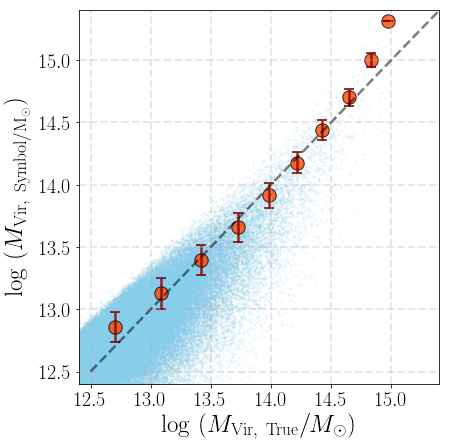

In [18]:
fig_3 = plt.figure(figsize=(6, 6))
fig_3.subplots_adjust(left=0.16, right=0.995, bottom=0.13, top=0.995, wspace=0.00, hspace=0.00)

ax1 = fig_3.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.3, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
# Scatter plot

logmh_symbol_mod = est_gp.predict(um_mass) 

ax1.scatter(um_mock_cen['logmh_vir'], logmh_symbol_mod, s=2, alpha=0.1, c='skyblue')

# Mean and std
logmh_bin = np.linspace(12.5, 15.4, 12)

idx_logmh = np.digitize(logmh_symbol_mod, logmh_bin)

logmh_mean_um = [np.nanmedian(um_mock_cen['logmh_vir'][idx_logmh == k]) 
                 for k in range(len(logmh_bin))]

logmh_mean_symbol = [np.nanmedian(logmh_symbol_mod[idx_logmh == k]) 
                    for k in range(len(logmh_bin))]

sigmh_symbol = [np.nanstd(um_mock_cen['logmh_vir'][idx_logmh == k]) 
               for k in range(len(logmh_bin))]

ax1.scatter(logmh_mean_um, logmh_mean_symbol, s=180, alpha=0.8, edgecolor='k',
            facecolor='orangered')

ax1.errorbar(logmh_mean_um, logmh_mean_symbol, yerr=np.asarray(sigmh_symbol)/2.0, 
             fmt='o', ecolor='maroon', elinewidth=2.5, capsize=5, capthick=2.0,
             color='orangered', markersize=0, alpha=0.8,
             markeredgecolor='none', zorder=1)

# One-to-one relation
ax1.plot(np.linspace(12.5, 15.9, 10), np.linspace(12.5, 15.9, 10), 
         linestyle='--', linewidth=2.5, c='k', alpha=0.5)

ax1.set_xlim(12.4, 15.4)
ax1.set_ylim(12.4, 15.4) 

_ = ax1.set_xlabel(r'$\log\ (M_{\rm Vir,\ True}/M_{\odot})$', fontsize=25)
_ = ax1.set_ylabel(r'$\log\ (M_{\rm Vir,\ Symbol/M_{\odot}})$', fontsize=25)

### Predict virial radius

In [21]:
# Read the UM mock catalog with additional information
um_vagc = np.load(
    os.path.join(cfg['um']['dir'], 'um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5.npy'))

mask_mass = um_vagc[cfg['um']['halo_col']] >= cfg['um']['min_mvir']

um_vagc_use = um_vagc[mask_mass]

# Make sure the galaxies are lined up
assert np.all(um_vagc_use['halo_id'] == um_data['um_mock']['halo_id'])

In [22]:
um_vagc.dtype

dtype([('halo_id', '<i8'), ('upid', '<i8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('mvir', '<f8'), ('mpeak', '<f8'), ('vmp', '<f8'), ('r', '<f8'), ('sm', '<f8'), ('icl', '<f8'), ('sfr', '<f8'), ('ssfr', '<f8'), ('pid', '<f8'), ('mvir_hlist', '<f8'), ('rvir_hlist', '<f8'), ('rs_hlist', '<f8'), ('scale_half_mass', '<f8'), ('scale_last_mm', '<f8'), ('m200b_hlist', '<f8'), ('m200c_hlist', '<f8'), ('gamma_inst', '<f8'), ('gamma_100myr', '<f8'), ('gamma_1tdyn', '<f8'), ('gamma_2tdyn', '<f8'), ('gamma_mpeak', '<f8'), ('vmax_mpeak', '<f8'), ('halo_hostid', '<i8'), ('mhalo_host', '<f8'), ('mask_central', '?'), ('mtot_galaxy', '<f8'), ('mstar_mhalo', '<f8'), ('logms_gal', '<f8'), ('logms_icl', '<f8'), ('logms_tot', '<f8'), ('logms_halo', '<f8'), ('logmh_vir', '<f8'), ('logmh_peak', '<f8'), ('logmh_host', '<f8')])

In [23]:
# Build the random forest regressor
rvir_forest = RandomForestRegressor(
    n_estimators=15, criterion='mse', max_depth=None, random_state=None, n_jobs=-1)

logr_vir_um_cen = np.log10(um_vagc_use[mask_use][mask_cen]['rvir_hlist'])

# Fit the data
rvir_forest.fit(um_mass, logr_vir_um_cen)

# Predict halo mass
logr_forest = rvir_forest.predict(hsc_aper_mass)

# Add a column
hsc_mhalo.add_column(Column(data=logr_forest, name='logr_vir_forest'))

# Save the model
joblib.dump(mstar_forest, 'data/um_asap_default_rvir_random_forest.pkl') 

['data/um_asap_default_rvir_random_forest.pkl']

/usr/local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1019: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


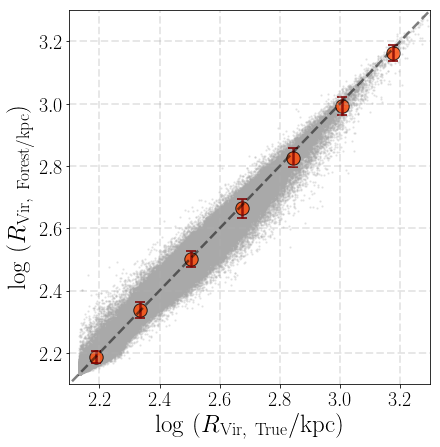

In [24]:
fig_4 = plt.figure(figsize=(6, 6))
fig_4.subplots_adjust(left=0.16, right=0.995, bottom=0.13, top=0.995, wspace=0.00, hspace=0.00)

ax1 = fig_4.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.3, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

# Scatter
um_rvir_forest = rvir_forest.predict(um_mass)

ax1.scatter(logr_vir_um_cen, um_rvir_forest, s=2, alpha=0.2, c='darkgray')

# Mean and std
logrvir_bin = np.linspace(2.1, 3.3, 8)

idx_logmh = np.digitize(logr_vir_um_cen, logrvir_bin)

logrvir_mean_um = [np.nanmedian(logr_vir_um_cen[idx_logmh == k]) 
                   for k in range(len(logrvir_bin))]

logrvir_mean_forest = [np.nanmedian(um_rvir_forest[idx_logmh == k]) 
                       for k in range(len(logrvir_bin))]

sigrvir_forest = [np.nanstd(um_rvir_forest[idx_logmh == k]) 
                  for k in range(len(logrvir_bin))]

ax1.scatter(logrvir_mean_um, logrvir_mean_forest, s=180, alpha=0.8, edgecolor='k',
            facecolor='orangered')

ax1.errorbar(logrvir_mean_um, logrvir_mean_forest, yerr=np.asarray(sigrvir_forest)/2.0, 
             fmt='o', ecolor='maroon', elinewidth=2.5, capsize=5, capthick=2.0,
             color='orangered', markersize=0, alpha=0.8,
             markeredgecolor='none', zorder=1)
    
ax1.plot(np.linspace(0.5, 3.9, 10), np.linspace(0.5, 3.9, 10), 
         linestyle='--', linewidth=2.5, c='k', alpha=0.5)

ax1.set_xlim(2.1, 3.3)
ax1.set_ylim(2.1, 3.3) 

_ = ax1.set_xlabel(r'$\log\ (R_{\rm Vir,\ True}/{\rm kpc})$', fontsize=25)
_ = ax1.set_ylabel(r'$\log\ (R_{\rm Vir,\ Forest/{\rm kpc}})$', fontsize=25)

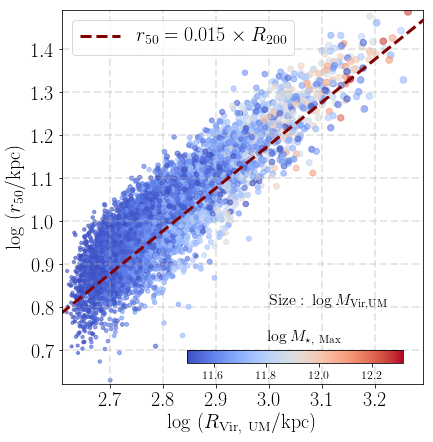

In [75]:
fig_5 = plt.figure(figsize=(6, 6))
fig_5.subplots_adjust(left=0.16, right=0.995, bottom=0.13, top=0.995, wspace=0.00, hspace=0.00)

ax1 = fig_5.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.3, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
ms_mask = hsc_mhalo['logm_max'] >= 11.5
    
SC = ax1.scatter(logr_forest[ms_mask], np.log10(hsc_mhalo[ms_mask]['r50_100']), alpha=0.6, 
                 c=(hsc_mhalo[ms_mask]['logm_max']), 
                 s=(hsc_mhalo[ms_mask]['logmh_vir_forest'] - 12.5) * 20,
                 label='__no_label__', cmap='coolwarm', vmin=11.5)

# r_n = 0.015 R200
rvir_arr = np.linspace(100, 2000, 500)
r50_arr = 0.015 * rvir_arr

ax1.plot(np.log10(rvir_arr), np.log10(r50_arr), linestyle='--', linewidth=3.0,
         c='maroon', label=r'$r_{50} = 0.015 \times R_{\rm 200}$')

_ = ax1.text(3.00, 0.8, r'$\mathrm{Size:\ }\log M_{\mathrm{Vir,UM}}$', fontsize=16)

# Colorbar
cax = fig_5.add_axes([0.45, 0.18, 0.50, 0.03])
cbar = plt.colorbar(SC, cax=cax, orientation='horizontal')
cbar.solids.set_edgecolor("face")

_ = ax1.text(0.57, 0.11, r'$\log M_{\star,\ \rm Max}$', transform=ax1.transAxes, size=16)

for tick in cax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in cax.yaxis.get_major_ticks():
    tick.label.set_fontsize(0)

ax1.legend(loc='upper left', fontsize=20)

ax1.set_xlim(2.61, 3.29)
ax1.set_ylim(0.62, 1.49)

_ = ax1.set_xlabel(r'$\log\ (R_{\rm Vir, \ UM}/\mathrm{kpc})$', fontsize=20)
_ = ax1.set_ylabel(r'$\log\ (r_{50}/\mathrm{kpc})$', fontsize=20)

### Save the HSC catalogs with Mvir

In [25]:
hsc_mhalo.write('../data/s16a_wide2_massive_fsps1_imgsub_use_mvir_added.fits', format='fits',
                overwrite=True)